In [1]:
%matplotlib inline


Robust linear estimator fitting
===============================

Here a sine function is fit with a polynomial of order 3, for values
close to zero.

Robust fitting is demoed in different situations:

- No measurement errors, only modelling errors (fitting a sine with a
  polynomial)

- Measurement errors in X

- Measurement errors in y

The median absolute deviation to non corrupt new data is used to judge
the quality of the prediction.

What we can see that:

- RANSAC is good for strong outliers in the y direction

- TheilSen is good for small outliers, both in direction X and y, but has
  a break point above which it performs worse than OLS.

- The scores of HuberRegressor may not be compared directly to both TheilSen
  and RANSAC because it does not attempt to completely filter the outliers
  but lessen their effect.




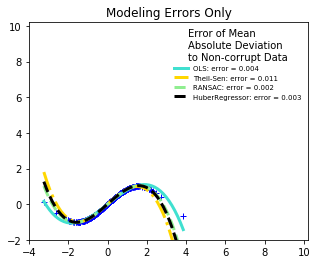

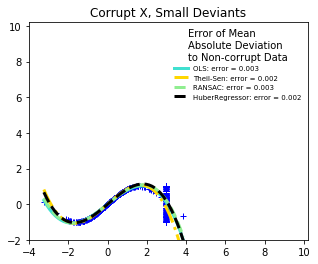

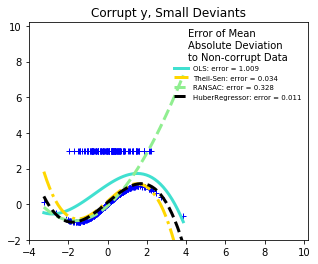

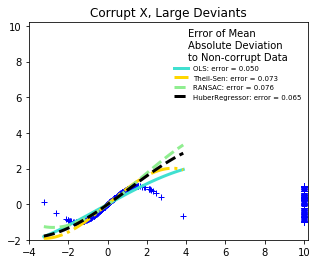

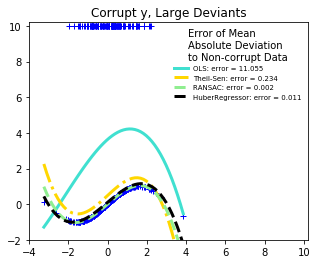

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
        ('Modeling Errors Only', X, y),
        ('Corrupt X, Small Deviants', X_errors, y),
        ('Corrupt y, Small Deviants', X, y_errors),
        ('Corrupt X, Large Deviants', X_errors_large, y),
        ('Corrupt y, Large Deviants', X, y_errors_large)]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, 'b+')

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
                 linewidth=lw, label='%s: error = %.3f' % (name, mse))

    legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
    legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()

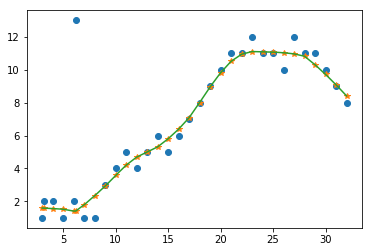

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import statsmodels.api as sm

# introduce some floats in our x-values
x = list(range(3, 33)) + [3.2, 6.2]
y = [1,2,1,2,1,1,3,4,5,4,5,6,5,6,7,8,9,10,11,11,12,11,11,10,12,11,11,10,9,8,2,13]

# x = [0., 2., 2.3, 5., 6.,7.,8.]
# y = [1,2,1.8,2,2,2,1.8]


# lowess will return our "smoothed" data with a y value for at every x-value
lowess = sm.nonparametric.lowess(y, x, frac=.3)

# unpack the lowess smoothed points to their values
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# run scipy's interpolation. There is also extrapolation I believe
f = interp1d(lowess_x, lowess_y, bounds_error=False)

xnew = [i/10. for i in range(400)]

# this this generate y values for our xvalues by our interpolator
# it will MISS values outsite of the x window (less than 3, greater than 33)
# There might be a better approach, but you can run a for loop
#and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
ynew = f(xnew)


plt.plot(x, y, 'o')
plt.plot(lowess_x, lowess_y, '*')
plt.plot(xnew, ynew, '-')
plt.show()